# Tutorial 2
## Detecting sleep state transitions using autoencoder-based Power Spectal Density (PSD) Clustering

In this tutorial, we handle the unknown data samples that the CNN was unable to classify with sufficient confidence (CL=90%). We begin by running autoencoders that were trained on each class using samples that did surpass the confidence bound. We then use the autoencoder corresponding to the class of maximal CNN confidence to compress and expand the data, denoising the signal.

In [1]:
# Import system modules
import os
import gc
import sys
import glob
import importlib
from google.colab import drive

# Import computational modules
import torch
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Import plotting modules
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Ellipse

In [2]:
# Mount repository to Google Colab
colab = True
if colab == True:
  drive.mount('/content/MyDrive', force_remount=True)
  os.chdir('/content/MyDrive/MyDrive/Courses/NeuralNetworks/e4040-fall2025-project-lsls/')

Mounted at /content/MyDrive


## Load the authors' per-class autoencoder models with saved weights

In [13]:
# Add file paths for author autoencoders

f_list = ["author_autoencoders/autoencoder_simpl_state_awake_epochs_150.h5",
          "author_autoencoders/autoencoder_simpl_state_slow_updown_epochs_150.h5",
          "author_autoencoders/autoencoder_simpl_state_slow_MA_epochs_150.h5",
          "author_autoencoders/autoencoder_simpl_state_asynch_MA_epochs_150.h5"]

In [14]:
# Load model
# Ignore warnings, we are only using model.predict and we don't need the optimizer state

autoencoders = {
    "Awake": load_model(f_list[0]),
    "Slow Up-Down": load_model(f_list[1]),
    "Slow MA": load_model(f_list[2]),
    "Asynch MA": load_model(f_list[3]),
}
states  = list(autoencoders.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Load data and metadata

from utils import preprocess
data, metadata = preprocess.load_data()
data = preprocess.normalize_data(data)

## Reconstruct denoised LFP signal using trained autoencoders

For each sample classified as unknown, falling below the CNN confidence bound of 90%, the autoencoder corresponding to the maximal CNN classification was run. The PSD was computed in the reconstructed samples across three primary frequency bands: delta (0.1–1 Hz), theta (4–8 Hz) and gamma (100–500 Hz).

First generate one test example, denoted x_hat, for visualization purposes. Then run the autoencoders and compute the PSD bands for the full dataset.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


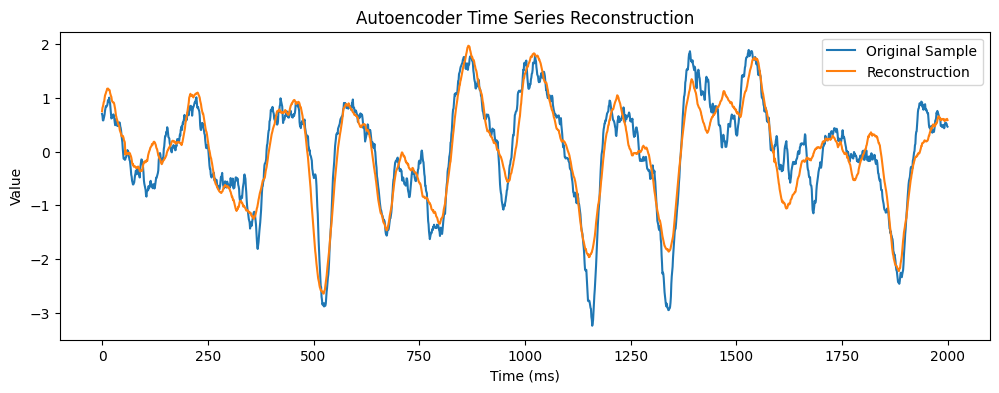

In [6]:
from utils.autoencoder_utils import prep_unknown_sample_df, gen_reconstruction

test_data, test_metadata = preprocess.reload_test_data(data, metadata)
f = "models/cnn_modified_optimized_0.9/unknown_df_cnn_modified_optimized_0.9.pkl"
df = prep_unknown_sample_df(f)
x_hat = gen_reconstruction(df, test_data, autoencoders)

In [7]:
# Compute PSD band powers for each unknown sample. This will take a minute to run, as we run the autoencoders on the full dataset
from utils.autoencoder_utils import compute_band_powers, append_psd_bands

powers, (f, Pxx) = compute_band_powers(x_hat)
print("PSD values for sample reconstruction")
print("Delta:", powers["delta"])
print("Theta:", powers["theta"])
print("Gamma:", powers["gamma"])

df = append_psd_bands(df, test_data, autoencoders)

PSD values for sample reconstruction
Delta: 0.031119442382987472
Theta: 0.3309653088763298
Gamma: 0.00012015929205929851


## Identify transition samples

Compute the PSD centroids for each class, and denote the transition centroid as the midpoint between class 2 (Slow MA) and class 3 (Asynch MA) samples. Add the "closer_to_transition" column to the df to provide Booleans for whether each sample lies closer to the transition centroid than the centroid of that sample's own class.

In [8]:
from utils.autoencoder_utils import compute_centroids

df = compute_centroids(df)
df.head()

,index,y_true,low_conf_pred,state,delta_power,theta_power,gamma_power,closer_to_transition
0,17,3,3,Slow MA,0.031119,0.330965,0.000120,True
1,36,3,3,Slow MA,0.031052,0.331802,0.000066,True
2,77,3,3,Slow MA,0.034208,0.414964,0.000084,False
3,86,3,3,Slow MA,0.020626,0.277729,0.000067,True
4,94,3,3,Slow MA,0.034161,0.357527,0.000066,True


In [9]:
# See distribution of data closer to the transition centroid per class

summary = df.groupby("y_true")["closer_to_transition"].value_counts().unstack(fill_value=0)
summary

closer_to_transition,False,True
y_true,,
0,43,10
1,15,2
2,73,50
3,174,145


## Plot transition detection

Show 9 samples that have been marked as 'transition' samples by the algorithm.

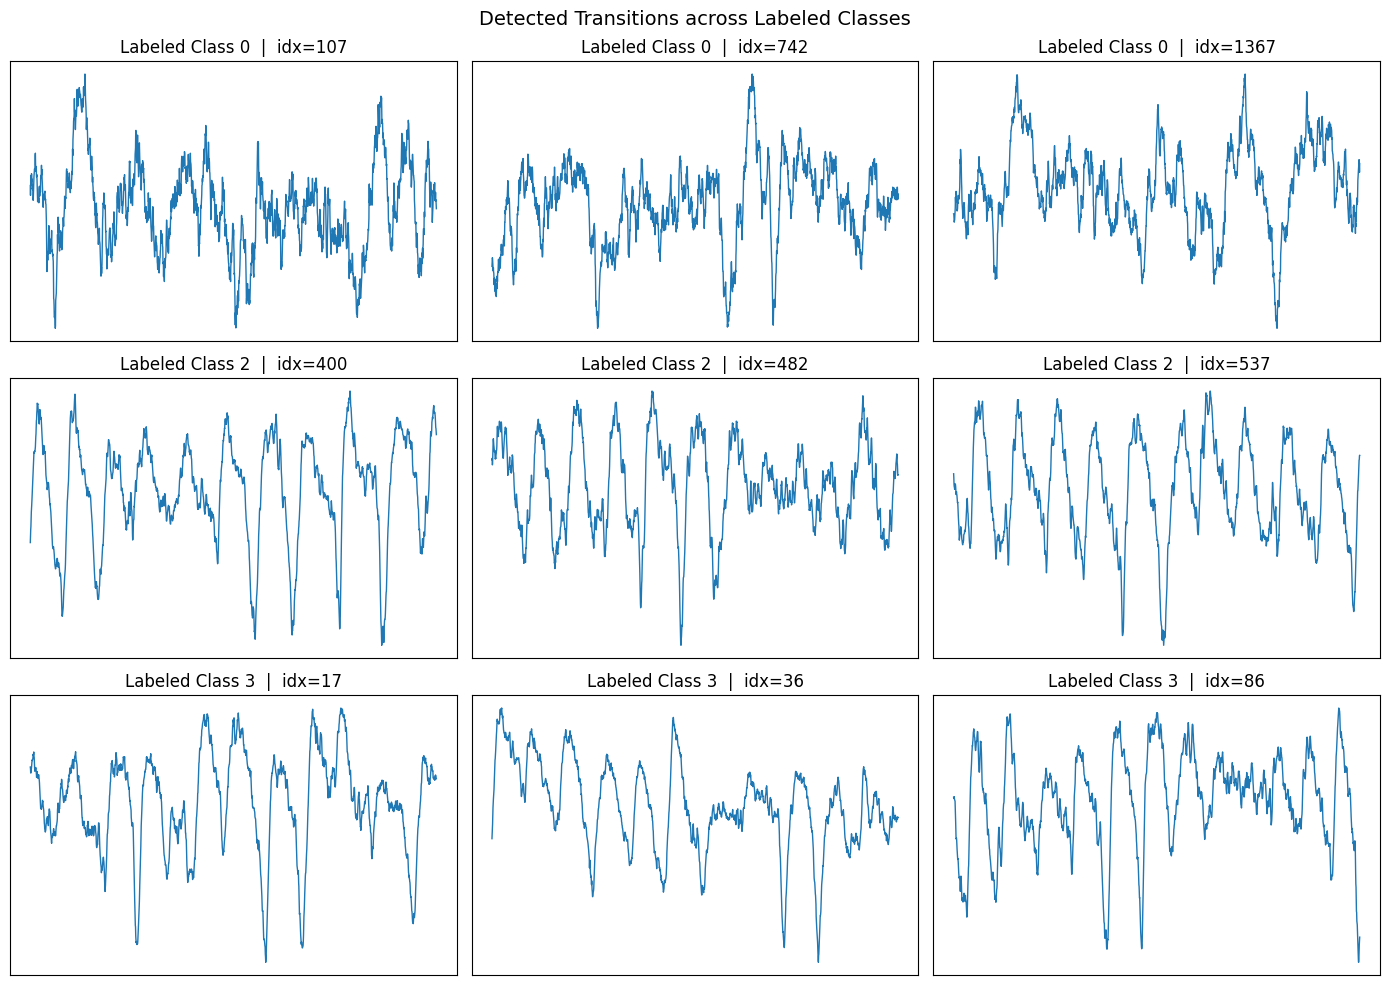

In [10]:
from utils.autoencoder_utils import plot_transitions_3by3

plot_transitions_3by3(df, test_data)

## Plot PSD

Plot the 3d PSD bands, clustered by class, with the transition class shown in orange.

/content/MyDrive/MyDrive/Courses/NeuralNetworks/e4040-fall2025-project-lsls/utils/autoencoder_utils.py:284: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


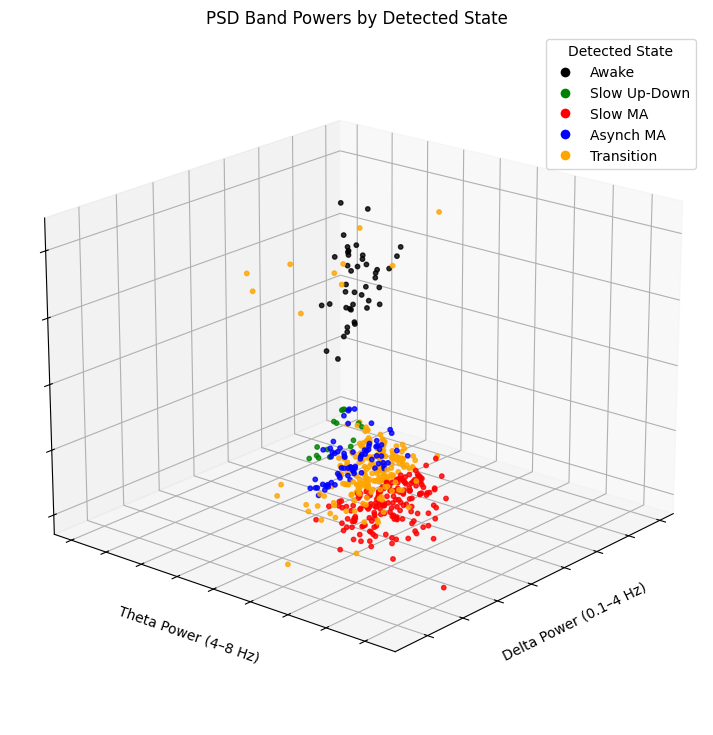

In [11]:
from utils.autoencoder_utils import build_colormap, plot_psd

df, color_map = build_colormap(df)
plot_psd(df, color_map)

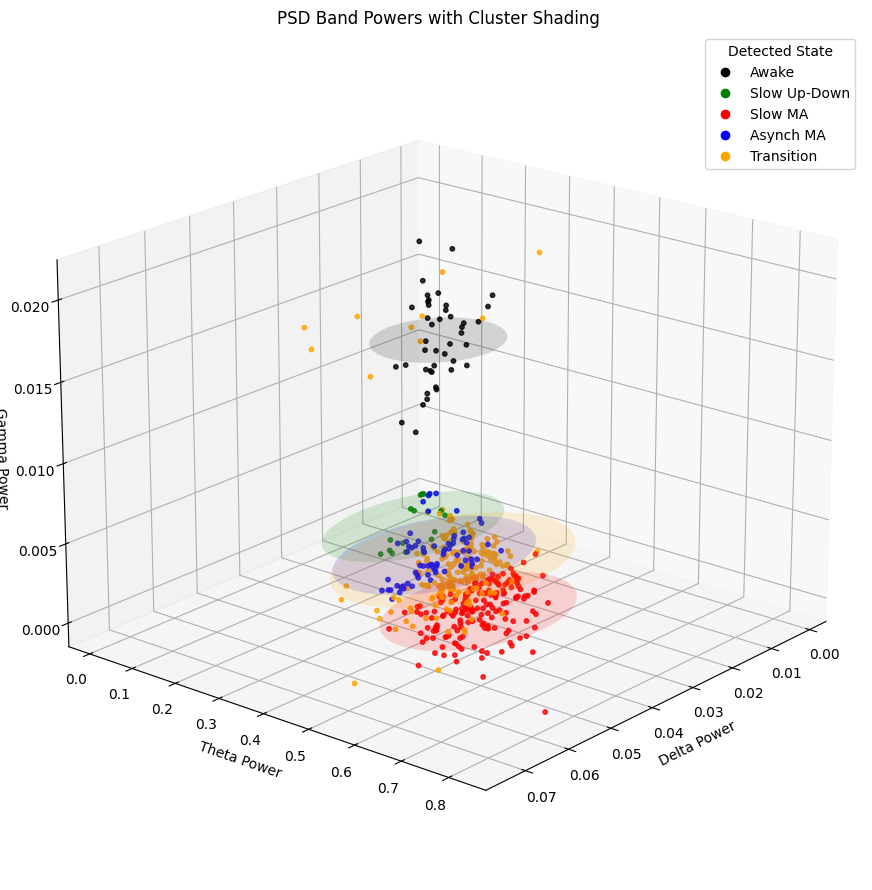

In [12]:
from utils.autoencoder_utils import build_colormap, plot_psd_ellipses

plot_psd_ellipses(df, color_map)